In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
from astropy.table import Table, Column
import pandas as pd
import numpy as np
from datetime import datetime
import time

In [2]:
####################################### Set Axes
def set_axes(ax, xlim=None, ylim=None, fontsize=16, twinx=True, twiny=True, minor=True, inout='in'):
        
        
        
        if not ylim is None:
            ax.set_ylim(ylim)
        else:
            ylim = ax.get_ylim() 
            
        if not xlim is None:    
            ax.set_xlim(xlim) 
        else:
            xlim = ax.get_xlim()
            
        ax.tick_params(which='major', length=6, width=1., direction=inout)
#         if minor:
        ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)  
        
        if twiny:
            y_ax = ax.twinx()
            y_ax.set_ylim(ylim)
            y_ax.set_yticklabels([])
            y_ax.minorticks_on()
            y_ax.tick_params(which='major', length=6, width=1., direction='in')
            if minor:
                y_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction='in') 

        if twinx:
            x_ax = ax.twiny()
            x_ax.set_xlim(xlim)
            x_ax.set_xticklabels([])
            x_ax.minorticks_on()
            x_ax.tick_params(which='major', length=6, width=1.0, direction='in')
            if minor:
                x_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction='in')     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        
        return x_ax, y_ax

In [3]:
#################################################################
def Vh2V3k(el,b, Vh):
  
    alpha = np.pi / 180.
    cosb = np.cos(b*alpha)
    sinb = np.sin(b*alpha)
    cosl = np.cos(el*alpha)
    sinl = np.sin(el*alpha)
    
    v3k = Vh-25.2*cosl*cosb-245.7*sinl*cosb+276.8*sinb

    return v3k

#################################################################

def Vcmb2Vmod(Vcmb, omegam=0.27):
    
    omegal=1.-omegam
    c=299800.
    z=Vcmb/c
    q0=0.5*(omegam-2.*omegal)
    fmod=1.+0.5*(1.-q0)*z-(1./6)*(1.-q0-3.*q0**2+1.)*z**2
    Vmod=c*z*fmod

    return Vmod
#################################################################

def Vh2Vls(el,b, Vh):
  
    alpha = np.pi / 180.
    cosb = np.cos(b*alpha)
    sinb = np.sin(b*alpha)
    cosl = np.cos(el*alpha)
    sinl = np.sin(el*alpha)
    
    vls = Vh-26.*cosl*cosb+317.*sinl*cosb-8.*sinb

    return vls
#################################################################

In [4]:
leda = pd.read_csv('Leda_bar.csv', delimiter='|')
leda = leda.set_index('PGC')

print(len(leda))

/home/ehsan/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (69,70,71,72,73,74,75,76) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


133229


In [5]:
df = pd.read_csv('6dfgs.csv', delimiter='|')
df["PGC1"] = df.apply(lambda x: x.PGC1 if x.PGC1 != 0 else x.PGC, axis=1)
df = df.rename(columns=lambda x: x.strip())
df = df.set_index('PGC')

ln10 = np.log(10.)
df['DM_6dfgs']  = (5*np.log10(df["D75"])+25.)
df['eDM_6dfgs'] = 5.*df["feD"]/ln10
df_6dfgs = df.rename(columns={"Nest": "Nest_6dfgs"})
df_6dfgs = df_6dfgs.rename(columns={"Vcmb": "Vcmb_6dfgs"})
df_6dfgs = df_6dfgs.rename(columns={"PGC1": "PGC1_6dfgs"})

df_6dfgs  = df_6dfgs[df_6dfgs['rej']==0]

print(len(df_6dfgs))

how = 'inner'
df_6dfgs = df_6dfgs.join(leda, lsuffix='_6dfgs', rsuffix='_leda', how=how)
df_6dfgs["SGL_6dfgs"] = df_6dfgs['sgl']
df_6dfgs["SGB_6dfgs"] = df_6dfgs['sgb']
print(len(df_6dfgs))

df_6dfgs.head()

7112
7112


,rej,PGC1_6dfgs,Nest_6dfgs,Name,Vcmb_6dfgs,Vgp,D75,D100,feD,DzDh,...,objname,objtype,type,bar,ring,multiple,compactness,angclass,SGL_6dfgs,SGB_6dfgs
PGC,,,,,,,,,,,,,,,,,,,,,
64,0,72642,200033,g0000523-355037,15324,14646,222.3,166.7,0.29,-0.034659,...,PGC000064,G,E,NaN,NaN,NaN,NaN,NaN,258.48008,1.38099
66,0,72642,200033,g0000532-355911,14725,14646,191.0,143.2,0.27,0.030506,...,PGC000066,G,E,NaN,NaN,NaN,NaN,NaN,258.34743,1.32816
114,0,72642,200033,g0001341-361900,14397,14397,133.6,100.2,0.27,0.177860,...,ESO349-018,G,S0-a,NaN,NaN,NaN,NaN,NaN,258.08627,1.08320
115,0,115,0,g0001453-042049,14005,14005,188.5,141.4,0.27,0.015661,...,PGC000115,G,Sab,NaN,NaN,NaN,NaN,NaN,288.52137,11.56921
123,0,123,205549,g0001361-144455,10966,10966,160.2,120.1,0.26,-0.023948,...,PGC000123,G,SABc,B,NaN,NaN,NaN,NaN,278.45999,8.40016


In [6]:
df = pd.read_csv('FP_sdss.csv', delimiter='|')
df["PGC1"] = df.apply(lambda x: x.PGC1 if x.PGC1 != 0 else x.PGC, axis=1)
df = df.rename(columns=lambda x: x.strip())
df = df.set_index('PGC')

df_fpsdss = df.rename(columns={"Nest": "Nest_fpsdss"})
df_fpsdss = df_fpsdss.rename(columns={"V": "Vcmb_fpsdss"})
df_fpsdss = df_fpsdss.rename(columns={"PGC1": "PGC1_fpsdss"})

df_fpsdss["SGL_fpsdss"] = df_fpsdss['sgl']
df_fpsdss["SGB_fpsdss"] = df_fpsdss['sgb']

print(len(df_fpsdss))

df_fpsdss.head()

24848


,Nest_fpsdss,PGC1_fpsdss,r,er,s,es,i,ei,Vcmb_fpsdss,j2000,glon,glat,sgl,sgb,Ty,objid,specid,SGL_fpsdss,SGB_fpsdss
PGC,,,,,,,,,,,,,,,,,,,
20919,104087,20919,0.6127,0.0100,2.4380,0.0168,2.5387,0.0200,16176,J072405.2+375711,180.4811,22.3382,33.5244,-35.9054,0.0,1237663547968323716,1951253584033114112,33.5244,-35.9054
21014,111419,21014,0.2976,0.0074,2.3298,0.0145,2.4564,0.0147,3248,J072635.4+431747,175.0475,24.3095,33.1155,-30.5520,-4.8,1237663917871988832,2099918005914855424,33.1155,-30.5520
21072,104427,21072,0.6410,0.0088,2.4632,0.0126,2.4982,0.0175,14977,J072817.0+400503,178.5264,23.7417,34.0922,-33.6721,-5.0,1237663531326243079,1951295365474969600,34.0922,-33.6721
21226,101391,21226,0.5074,0.0079,2.4432,0.0091,2.6399,0.0159,16282,J073216.9+315248,187.2764,22.0116,37.0397,-41.5798,-2.0,1237653588476952852,609190772427745280,37.0397,-41.5798
21354,0,21354,1.3888,0.0095,2.4712,0.0359,1.6450,0.0189,26329,J073536.4+394554,179.2853,25.0050,35.8219,-33.7250,-5.0,1237673703967031397,486471804492212224,35.8219,-33.7250


In [7]:
df = pd.read_csv('all_cf2_fp.csv', delimiter='|')
df["PGC1"] = df.apply(lambda x: x.PGC1 if x.PGC1 != 0 else x.PGC, axis=1)
df = df.rename(columns=lambda x: x.strip())
df_cf2fp = df.set_index('PGC')

df_cf2fp = df_cf2fp.rename(columns={"Nest": "Nest_cf2fp"})
df_cf2fp = df_cf2fp.rename(columns={"Vcmb": "Vcmb_cf2fp"})
df_cf2fp = df_cf2fp.rename(columns={"PGC1": "PGC1_cf2fp"})

df_cf2fp["SGL_cf2fp"] = df_cf2fp['SGL']
df_cf2fp["SGB_cf2fp"] = df_cf2fp['SGB']

print(len(df_cf2fp))

df_cf2fp.head()

1508


,Dist,PGC1_cf2fp,Nest_cf2fp,Name,RAJ,DeJ,Glon,Glat,SGL,SGB,...,DMfar,logV,Vcl,NameS,NameN,NameF,Lclust,Bclust,SGL_cf2fp,SGB_cf2fp
PGC,,,,,,,,,,,,,,,,,,,,,
1339,49.0,1351,200045,PGC001339,2051.8,213211.7,113.5283,-40.7762,315.4088,13.4349,...,0.0,3.788,5804,7S21,7S21,NaN,0.0,0.0,315.4088,13.4349
1340,83.6,1351,200045,NGC0079,2102.8,223359.0,113.7925,-39.7654,316.4548,13.6021,...,0.0,3.758,5804,7S21,7S21,NaN,0.0,0.0,316.4548,13.6021
1351,76.2,1351,200045,NGC0080,2110.9,222126.1,113.7906,-39.9768,316.2505,13.5297,...,0.0,3.776,5804,7S21,7S21,NaN,0.0,0.0,316.2505,13.5297
1371,83.2,1351,200045,NGC0083,2122.5,222600.8,113.8635,-39.9082,316.3366,13.5013,...,0.0,3.810,5804,7S21,7S21,NaN,0.0,0.0,316.3366,13.5013
1375,56.2,1351,200045,NGC0085,2125.6,223042.1,113.8942,-39.8328,316.4178,13.5054,...,0.0,3.808,5804,7S21,7S21,NaN,0.0,0.0,316.4178,13.5054


In [8]:
how = 'outer'
df = df_6dfgs.join(df_cf2fp, lsuffix='_6dfgs', rsuffix='_cf2fp', how=how)
df = df.join(df_fpsdss, lsuffix='_l', rsuffix='_fpsdss', how=how)


catalogs = ["6dfgs", "cf2fp", "fpsdss"]

ss = []
for cat in catalogs:
    ss += ['PGC1_'+cat, "Vcmb_"+cat, 'SGL_'+cat, "SGB_"+cat]


df = df[ss]
print(len(df))


ss = []
for cat in catalogs:
    ss += ['PGC1_'+cat]   
df['PGC1'] = df[ss].median(axis=1)
df = df[~df['PGC1'].isna()]

ss = []
for cat in catalogs:
    ss += ['Vcmb_'+cat]   
df['Vcmb'] = df[ss].mean(axis=1)


df.head()

33040


,PGC1_6dfgs,Vcmb_6dfgs,SGL_6dfgs,SGB_6dfgs,PGC1_cf2fp,Vcmb_cf2fp,SGL_cf2fp,SGB_cf2fp,PGC1_fpsdss,Vcmb_fpsdss,SGL_fpsdss,SGB_fpsdss,PGC1,Vcmb
PGC,,,,,,,,,,,,,,
64,72642.0,15324.0,258.48008,1.38099,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72642.0,15324.0
66,72642.0,14725.0,258.34743,1.32816,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72642.0,14725.0
114,72642.0,14397.0,258.08627,1.08320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72642.0,14397.0
115,115.0,14005.0,288.52137,11.56921,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,115.0,14005.0
123,123.0,10966.0,278.45999,8.40016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,123.0,10966.0


In [9]:
dg = df.groupby('PGC1').agg(["mean", "count"])

dg.head()

PGC1_6dfgs          Vcmb_6dfgs         SGL_6dfgs        SGB_6dfgs        \
            mean count          mean count        mean count       mean count   
PGC1                                                                            
75.0        75.0     5  11619.800000     5  251.056466     5  -1.604270     5   
115.0      115.0     1  14005.000000     1  288.521370     1  11.569210     1   
123.0      123.0     1  10966.000000     1  278.459990     1   8.400160     1   
211.0      211.0     7  10550.142857     7  241.580481     7  -5.517797     7   
262.0      262.0     1   8795.000000     1  251.387160     1  -1.854540     1   

      PGC1_cf2fp        ... PGC1_fpsdss       Vcmb_fpsdss       SGL_fpsdss  \
            mean count  ...        mean count        mean count       mean   
PGC1                    ...                                                  
75.0         NaN     0  ...         NaN     0         NaN     0        NaN   
115.0        NaN     0  ...         NaN     0         NaN     0        NaN   
123.0        NaN     0  ...         NaN     0         NaN     0        NaN   
211.0        NaN     0  ...         NaN     0         NaN     0        NaN   
262.0        NaN     0  ...         NaN     0         NaN     0        NaN   

            SGB_fpsdss                Vcmb        
      count       mean count          mean count  
PGC1                                              
75.0      0        NaN     0  11619.800000     5  
115.0     0        NaN     0  14005.000000     1  
123.0     0        NaN     0  10966.000000     1  
211.0     0        NaN     0  10550.142857     7  
262.0     0        NaN     0   8795.000000     1  

[5 rows x 26 columns]

In [10]:
dg.loc[115].Vcmb['count']

1.0

In [11]:
df["Vgrp"] = df["PGC1"].apply(lambda x: dg.loc[x].Vcmb['mean'])
df["Ngrp"] = df["PGC1"].apply(lambda x: dg.loc[x].Vcmb['count'])

df.head()

,PGC1_6dfgs,Vcmb_6dfgs,SGL_6dfgs,SGB_6dfgs,PGC1_cf2fp,Vcmb_cf2fp,SGL_cf2fp,SGB_cf2fp,PGC1_fpsdss,Vcmb_fpsdss,SGL_fpsdss,SGB_fpsdss,PGC1,Vcmb,Vgrp,Ngrp
PGC,,,,,,,,,,,,,,,,
64,72642.0,15324.0,258.48008,1.38099,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72642.0,15324.0,13983.272727,11.0
66,72642.0,14725.0,258.34743,1.32816,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72642.0,14725.0,13983.272727,11.0
114,72642.0,14397.0,258.08627,1.08320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72642.0,14397.0,13983.272727,11.0
115,115.0,14005.0,288.52137,11.56921,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,115.0,14005.0,14005.000000,1.0
123,123.0,10966.0,278.45999,8.40016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,123.0,10966.0,10966.000000,1.0


In [12]:
df = df.sort_values(by=['Vgrp', 'PGC1'], ascending=False)

print(len(df))

df.head(20)

33040


,PGC1_6dfgs,Vcmb_6dfgs,SGL_6dfgs,SGB_6dfgs,PGC1_cf2fp,Vcmb_cf2fp,SGL_cf2fp,SGB_cf2fp,PGC1_fpsdss,Vcmb_fpsdss,SGL_fpsdss,SGB_fpsdss,PGC1,Vcmb,Vgrp,Ngrp
PGC,,,,,,,,,,,,,,,,
1102190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1102190.0,30315.0,115.3905,-11.4616,1102190.0,30315.0,30315.0,1.0
1217037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1217037.0,30303.0,108.5295,-19.0059,1217037.0,30303.0,30303.0,1.0
3461155,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3461155.0,30296.0,89.4890,-39.8094,3461155.0,30296.0,30296.0,1.0
3781476,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3781476.0,30288.0,95.0188,-6.8807,3781476.0,30288.0,30288.0,1.0
1687673,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1687673.0,30287.0,89.7761,-6.6211,1687673.0,30287.0,30287.0,1.0
1194559,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1194559.0,30287.0,108.8929,-20.2823,1194559.0,30287.0,30287.0,1.0
1190970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1190970.0,30285.0,108.8062,-20.9302,1190970.0,30285.0,30285.0,1.0
1422325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1422325.0,30256.0,98.2414,-14.0256,1422325.0,30256.0,30256.0,1.0
1454197,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1454197.0,30255.0,94.3352,-20.1875,1454197.0,30255.0,30255.0,1.0


In [13]:
cols = [x for x in df.columns]

print(len(df))

df.head()

33040


,PGC1_6dfgs,Vcmb_6dfgs,SGL_6dfgs,SGB_6dfgs,PGC1_cf2fp,Vcmb_cf2fp,SGL_cf2fp,SGB_cf2fp,PGC1_fpsdss,Vcmb_fpsdss,SGL_fpsdss,SGB_fpsdss,PGC1,Vcmb,Vgrp,Ngrp
PGC,,,,,,,,,,,,,,,,
1102190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1102190.0,30315.0,115.3905,-11.4616,1102190.0,30315.0,30315.0,1.0
1217037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1217037.0,30303.0,108.5295,-19.0059,1217037.0,30303.0,30303.0,1.0
3461155,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3461155.0,30296.0,89.4890,-39.8094,3461155.0,30296.0,30296.0,1.0
3781476,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3781476.0,30288.0,95.0188,-6.8807,3781476.0,30288.0,30288.0,1.0
1687673,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1687673.0,30287.0,89.7761,-6.6211,1687673.0,30287.0,30287.0,1.0


In [14]:
ss = []
for cat in catalogs:
    ss += ['SGL_'+cat]   
df['sgl'] = df[ss].mean(axis=1)

ss = []
for cat in catalogs:
    ss += ['SGB_'+cat]   
df['sgb'] = df[ss].mean(axis=1)

df.head()

,PGC1_6dfgs,Vcmb_6dfgs,SGL_6dfgs,SGB_6dfgs,PGC1_cf2fp,Vcmb_cf2fp,SGL_cf2fp,SGB_cf2fp,PGC1_fpsdss,Vcmb_fpsdss,SGL_fpsdss,SGB_fpsdss,PGC1,Vcmb,Vgrp,Ngrp,sgl,sgb
PGC,,,,,,,,,,,,,,,,,,
1102190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1102190.0,30315.0,115.3905,-11.4616,1102190.0,30315.0,30315.0,1.0,115.3905,-11.4616
1217037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1217037.0,30303.0,108.5295,-19.0059,1217037.0,30303.0,30303.0,1.0,108.5295,-19.0059
3461155,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3461155.0,30296.0,89.4890,-39.8094,3461155.0,30296.0,30296.0,1.0,89.4890,-39.8094
3781476,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3781476.0,30288.0,95.0188,-6.8807,3781476.0,30288.0,30288.0,1.0,95.0188,-6.8807
1687673,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1687673.0,30287.0,89.7761,-6.6211,1687673.0,30287.0,30287.0,1.0,89.7761,-6.6211


In [15]:
len(df)

33040

In [16]:
import matplotlib.ticker

class OOMFormatter(matplotlib.ticker.ScalarFormatter):
    def __init__(self, order=0, fformat="%1.1f", offset=True, mathText=True):
        self.oom = order
        self.fformat = fformat
        matplotlib.ticker.ScalarFormatter.__init__(self,useOffset=offset,useMathText=mathText)
    def _set_orderOfMagnitude(self, nothing):
        self.orderOfMagnitude = self.oom
    def _set_format(self, vmin, vmax):
        self.format = self.fformat
        if self._useMathText:
            self.format = '$%s$' % matplotlib.ticker._mathdefault(self.format)

In [17]:
df.columns

Index([u'PGC1_6dfgs', u'Vcmb_6dfgs', u'SGL_6dfgs', u'SGB_6dfgs', u'PGC1_cf2fp',
       u'Vcmb_cf2fp', u'SGL_cf2fp', u'SGB_cf2fp', u'PGC1_fpsdss',
       u'Vcmb_fpsdss', u'SGL_fpsdss', u'SGB_fpsdss', u'PGC1', u'Vcmb', u'Vgrp',
       u'Ngrp', u'sgl', u'sgb'],
      dtype='object')

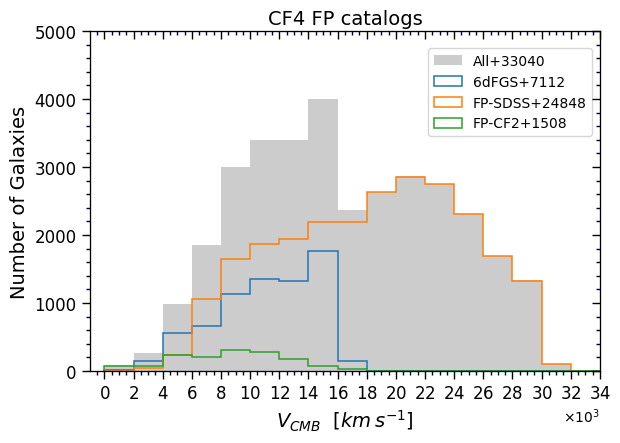

In [18]:
fig = plt.figure(figsize=(6, 4), dpi=100)
ax = fig.add_axes([0.13, 0.1, 0.85,  0.85])

bins=np.arange(0,36000,2000)

val = df.Vcmb.values
ax.hist(val, bins=bins, histtype='bar', label='All+'+str(len(val)), color='k', lw=1.7, alpha=0.2) 

val = df[~df["Vcmb_6dfgs"].isna()]["Vcmb"].values
ax.hist(val, bins=bins, histtype='step', label='6dFGS+'+str(len(val)), lw=1.1) 

val = df[~df["Vcmb_fpsdss"].isna()]["Vcmb"].values
ax.hist(val, bins=bins, histtype='step', label='FP-SDSS+'+str(len(val)), lw=1.1) 

val = df[~df["Vcmb_cf2fp"].isna()]["Vcmb"].values
ax.hist(val, bins=bins, histtype='step', label='FP-CF2+'+str(len(val)), lw=1.1) 

x_ax, y_ax = set_axes(ax, [-1000,34000], [0,5000], fontsize=12, inout='out')


ax.set_xlabel(r"$V_{CMB}$"+"  "+r'$[km \/ s^{-1}]$', fontsize=14)
ax.set_ylabel("Number of Galaxies", fontsize=14)

ax.legend(bbox_to_anchor=(0.65, 0.97), loc='upper left', fontsize=10)

x_ax.set_xticks(np.arange(0, 36000, step=2000))
ax.set_xticks(np.arange(0, 36000, step=2000))


ax.set_title("CF4 FP catalogs", fontsize=14, pad=5)

ax.xaxis.set_major_formatter(OOMFormatter(3, "%d"))
ax.ticklabel_format(axis='x', style='sci')

In [19]:
import copy

df_all = copy.deepcopy(df)



In [20]:
import sys
import os
import random
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import  lines
from matplotlib import rc, rcParams
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib.patches import Polygon, Ellipse
import numpy as np
from math import *
from time import time
import wl_to_rgb as col
import random
from astropy.io import ascii
from astropy.table import Table, Column 
import pyfits
import pylab as py
from astropy import coordinates as coord
from astropy import units as unit
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.patches as mpatches

from matplotlib import *

In [21]:
df = df_all[df_all["Vgrp"]<16000]

vel = df.Vcmb.values
vel = df.Vgrp.values

print np.min(vel), np.max(vel)


1049.0 15999.25


In [22]:
len(df)

17002

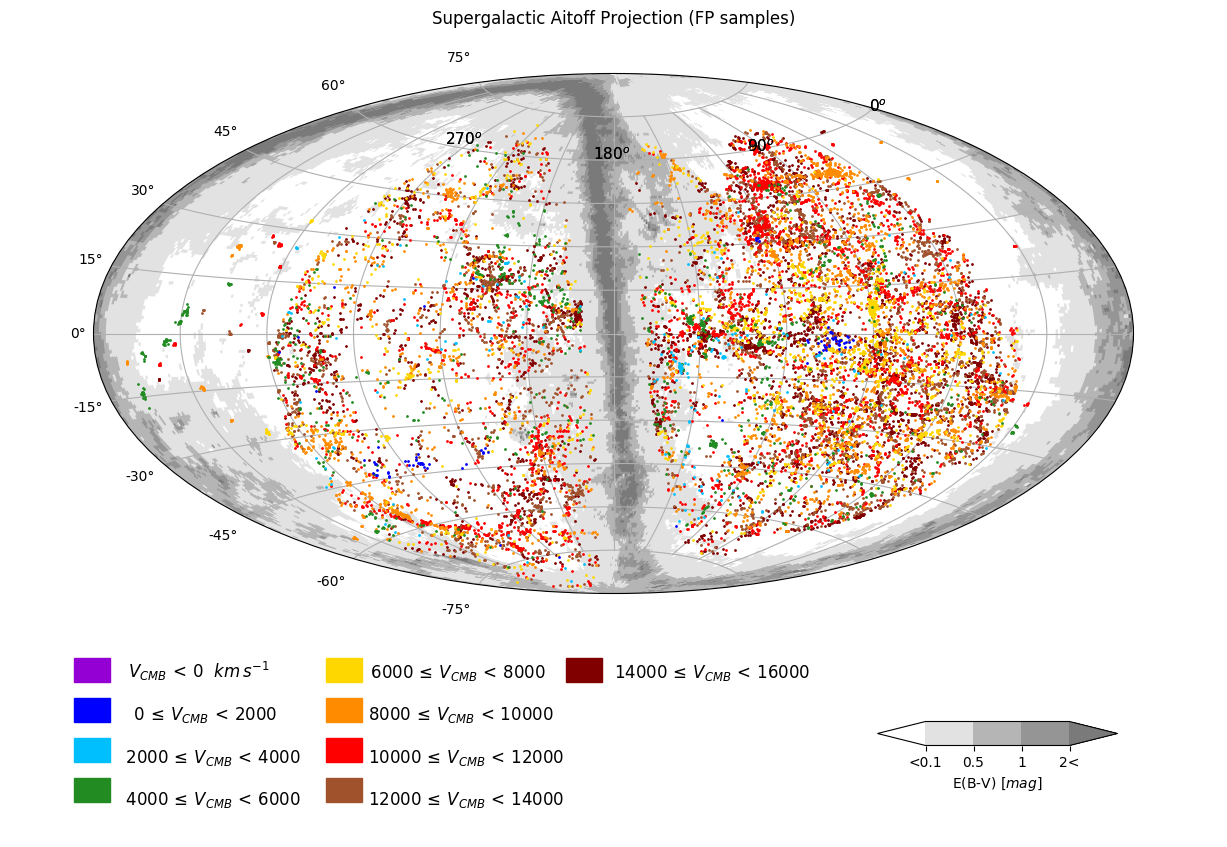

In [23]:
l0 = 180

deg = 0.8
a = pyfits.open('EBV.0.8.deg.fits')
d = a[1].data

SGL  = d['SGL']
SGB  = d['SGB']
EBV = d['EBV']

fig = plt.figure(figsize=(12, 8), dpi=100)
ax = fig.add_subplot(111, projection="aitoff")
plt.title("Supergalactic Aitoff Projection (FP samples)", y=1.08)
ax.grid(True)
ax.set_xticklabels([])
plt.subplots_adjust(top=0.95, bottom=0.3, right=0.95, left=0.05)

ax.annotate(r'$0^o$', (pi-0.1,pi/3.), size=11, color='black')
ax.annotate(r'$90^o$', (pi/2.-0.2,pi/3.), size=11, color='black')
ax.annotate(r'$180^o$', (-0.2,pi/3.), size=11, color='black')
ax.annotate(r'$270^o$', (-pi/2.-0.2,pi/3.), size=11, color='black')


ax.annotate(r'$0^o$', (pi-0.1,pi/3.), size=11, color='black')
ax.annotate(r'$90^o$', (pi/2.-0.2,pi/3.), size=11, color='black')
ax.annotate(r'$180^o$', (-0.2,pi/3.), size=11, color='black')
ax.annotate(r'$270^o$', (-pi/2.-0.2,pi/3.), size=11, color='black')  
################################################################ 
################################################################ 
def xymap_aitoff(x, y):
  
    while x > 360:
        x-=360
    while x < 0:
        x+=360

    x0 = (180.-x)*pi/180.
    y0 = y*pi/180.
  
    return x0, y0
################################################################ 

def esn_aitoff_patch(ax, x0, y0, d, color='blue'):

    vertices = []
    x, y = xymap_aitoff(x0,y0) 
    vertices.append([x,y])
    x, y = xymap_aitoff(x0,y0+d) 
    vertices.append([x,y])
    x, y = xymap_aitoff(x0+d,y0+d) 
    vertices.append([x,y])
    x, y = xymap_aitoff(x0+d,y0) 
    vertices.append([x,y]) 
    ax.add_patch(Polygon(vertices, closed=True, fill=True, color=color))


jet = cm = plt.get_cmap('Greys')
cNorm  = colors.Normalize(vmin=0, vmax=5)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

for i in range(len(SGB)):
    if EBV[i]>2.0: val = 3
    elif EBV[i]>1.0: val = 2.5
    elif EBV[i]>0.5: val= 2.0
    elif EBV[i]<=0.5 and EBV[i]>0.1: val= 1.0
    elif EBV[i]<0.1: val= 0
    else: val= 0
    colorVal = scalarMap.to_rgba(val)
    esn_aitoff_patch(ax, SGL[i], SGB[i], deg, color=colorVal)

    
    
# N = len(SGL)
# X = np.zeros(N)
# Y = np.zeros(N)
# for i in range(N):
#     X[i], Y[i] = xymap_aitoff(SGL[i], SGB[i])    
# ax.scatter(X, Y, marker='.', color='black')


sgl_gal = df.sgl.values
sgb_gal = df.sgb.values
N = len(sgl_gal)
X = np.zeros(N)
Y = np.zeros(N)
for i in range(N):
    X[i], Y[i] = xymap_aitoff(sgl_gal[i], sgb_gal[i])
    
############################################
    
# vel_col = np.zeros(N)   
# Velocity = df.Vcmb.values
# for i, v in enumerate(vel):
#     vel_col[i] = 0
#     if v<=0:
#         vel_col[i] = 0.1
#     elif v>=11000:
#         vel_col[i] = 1
#     else:
#         vel_col[i] = 0.1+0.9*v/11000.
    
# colours = pl.cm.nipy_spectral(vel_col)

############################################
col_pallet = ['darkviolet', 'blue', 'deepskyblue', 'forestgreen', 'gold', 'darkorange', 'red', 'sienna', 'maroon']
vel_pallet = [-100000, 0, 2000, 4000, 6000, 8000, 10000, 12000, 14000, 16000]
def color_table(Velocity):
    colours = []
    for j, v in enumerate(Velocity):
        col = "white"
        for i in range(len(vel_pallet)-1):
            if vel_pallet[i] <= v and v < vel_pallet[i+1]:
                col = col_pallet[i]
                break
        colours.append(col)
    return colours

colours = color_table(df.Vgrp.values)
############################################

ax2 = plt.axes([0,0,1,1], facecolor=(1,1,1,0))
ax2.set_axis_off()
ax2.set_xticks([])
ax2.set_yticks([])
ax2.xaxis.set_ticks_position('none')
ax2.yaxis.set_ticks_position('none')
ax2.annotate(r"$\/\/ V_{CMB} \/ < \/ 0 \/\/\/\/ km\/ s^{-1}  $", (0.1,0.2), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$ \/\/\/\/ 0 \/ \leq \/ V_{CMB} \/ < \/ 2000$', (0.1,0.2-0.05), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$\/ 2000 \/ \leq \/ V_{CMB} \/ < \/ 4000$', (0.1,0.2-2*0.05), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$\/ 4000 \/ \leq \/ V_{CMB} \/ < \/ 6000$', (0.1,0.2-3*0.05), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$\/ 6000 \/ \leq \/ V_{CMB} \/ < \/ 8000$', (0.30,0.2), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$8000 \/ \leq \/ V_{CMB} \/ < \/ 10000$', (0.30,0.2-0.05), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$10000 \/ \leq \/ V_{CMB} \/ < \/ 12000$', (0.30,0.2-2*0.05), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$12000 \/ \leq \/ V_{CMB} \/ < \/ 14000$', (0.30,0.2-3*0.05), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$14000 \/ \leq \/ V_{CMB} \/ < \/ 16000$', (0.5,0.2), xycoords='figure fraction', size=12, color='black')
# ax2.annotate(r'$16000 \/ \leq \/ V_{CMB}$', (0.50,0.2-0.05), xycoords='figure fraction', size=12, color='black')

try:
    p = 0
    for m in [0.1,0.31,0.51]:
        for n in [0.19,0.19-0.05,0.19-2*0.05,0.19-3*0.05]:
            ax2.add_patch(patches.Rectangle((m-0.05, n), 0.03, 0.03, color=col_pallet[p]))
            p+=1
    # ax2.add_patch(patches.Rectangle((0.71-0.05, 0.19), 0.03, 0.03, color=col_pallet[p]))
except:
    pass
############################################
################################################################ 
jet = cm = plt.get_cmap('Greys')
cNorm  = colors.Normalize(vmin=0, vmax=5)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
ax3 = fig.add_axes([0.720, 0.11, 0.2, 0.03])
cols = []
bounds = [0,1,2,3]
#cols.append(scalarMap.to_rgba(0))
cols.append(scalarMap.to_rgba(1.0))
cols.append(scalarMap.to_rgba(2.0))
cols.append(scalarMap.to_rgba(2.5))
#cols.append(scalarMap.to_rgba(3.0))


cm = colors.ListedColormap(cols)

cm.set_over(scalarMap.to_rgba(3.0))
cm.set_under(scalarMap.to_rgba(0))

cNorm  = colors.BoundaryNorm(bounds, cm.N)
cbar = colorbar.ColorbarBase(ax3, cmap=cm, norm=cNorm, orientation='horizontal',ticks=bounds, boundaries=[-1]+bounds+[4],extend='both',extendfrac='auto')
cbar.set_ticks(bounds)
cbar.ax.tick_params(labelsize=10) 
cbar.ax.set_xticklabels(['<0.1','0.5','1','2<'])  # horizontal colorbar

cbar.set_label('E(B-V) '+r'$[mag]$')
################################################################   

for i, c in enumerate(colours):
    ax.plot([X[i]], [Y[i]], color=c, marker='.', ms=2)
    

In [24]:
df = df_all[df_all["Vgrp"]>=16000]

vel = df.Vcmb.values
vel = df.Vgrp.values

print np.min(vel), np.max(vel)


16000.0 30315.0


In [25]:
len(df)

16038

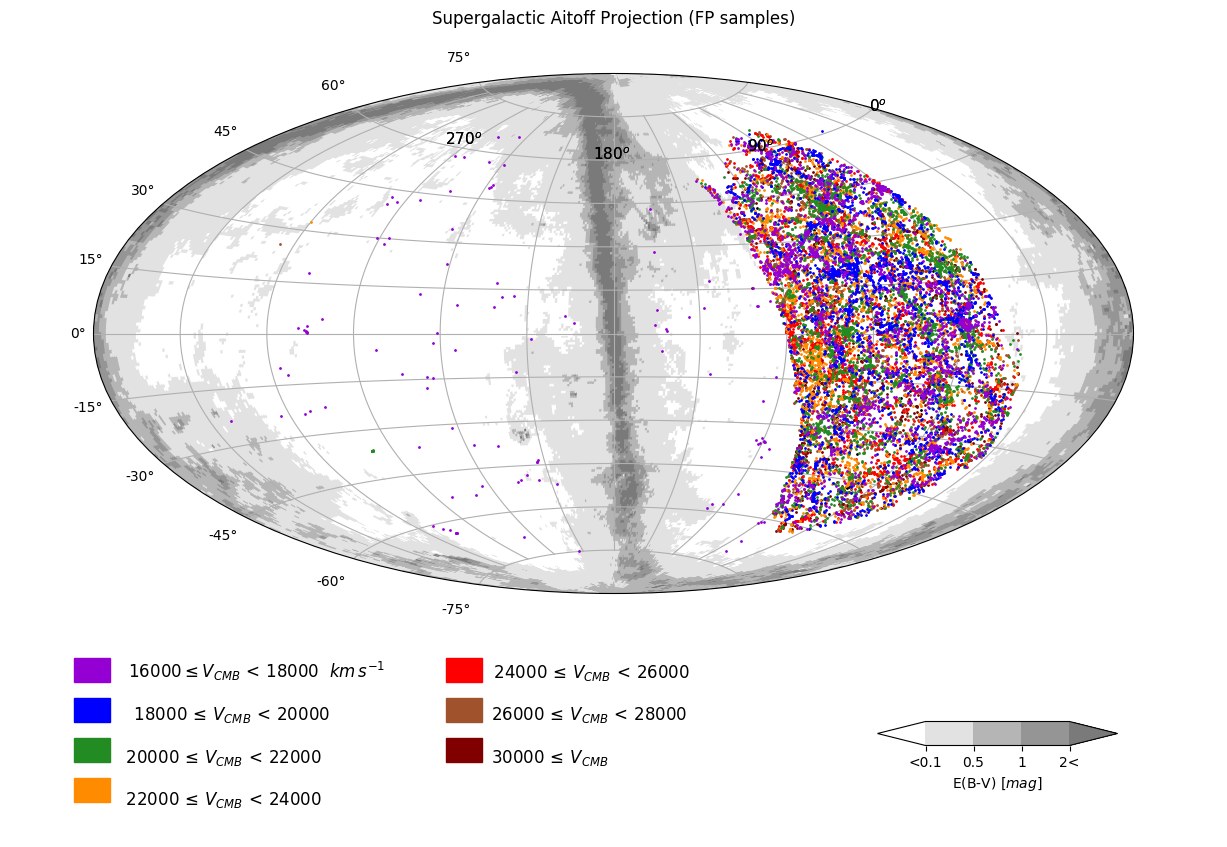

In [26]:
l0 = 180

deg = 0.8
a = pyfits.open('EBV.0.8.deg.fits')
d = a[1].data


SGL  = d['SGL']
SGB  = d['SGB']
EBV = d['EBV']

fig = plt.figure(figsize=(12, 8), dpi=100)
ax = fig.add_subplot(111, projection="aitoff")
plt.title("Supergalactic Aitoff Projection (FP samples)", y=1.08)
ax.grid(True)
ax.set_xticklabels([])
plt.subplots_adjust(top=0.95, bottom=0.3, right=0.95, left=0.05)

ax.annotate(r'$0^o$', (pi-0.1,pi/3.), size=11, color='black')
ax.annotate(r'$90^o$', (pi/2.-0.2,pi/3.), size=11, color='black')
ax.annotate(r'$180^o$', (-0.2,pi/3.), size=11, color='black')
ax.annotate(r'$270^o$', (-pi/2.-0.2,pi/3.), size=11, color='black')


ax.annotate(r'$0^o$', (pi-0.1,pi/3.), size=11, color='black')
ax.annotate(r'$90^o$', (pi/2.-0.2,pi/3.), size=11, color='black')
ax.annotate(r'$180^o$', (-0.2,pi/3.), size=11, color='black')
ax.annotate(r'$270^o$', (-pi/2.-0.2,pi/3.), size=11, color='black')  
################################################################ 
################################################################ 
def xymap_aitoff(x, y):
  
    while x > 360:
        x-=360
    while x < 0:
        x+=360

    x0 = (180.-x)*pi/180.
    y0 = y*pi/180.
  
    return x0, y0
################################################################ 

def esn_aitoff_patch(ax, x0, y0, d, color='blue'):

    vertices = []
    x, y = xymap_aitoff(x0,y0) 
    vertices.append([x,y])
    x, y = xymap_aitoff(x0,y0+d) 
    vertices.append([x,y])
    x, y = xymap_aitoff(x0+d,y0+d) 
    vertices.append([x,y])
    x, y = xymap_aitoff(x0+d,y0) 
    vertices.append([x,y]) 
    ax.add_patch(Polygon(vertices, closed=True, fill=True, color=color))


jet = cm = plt.get_cmap('Greys')
cNorm  = colors.Normalize(vmin=0, vmax=5)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

for i in range(len(SGB)):
    if EBV[i]>2.0: val = 3
    elif EBV[i]>1.0: val = 2.5
    elif EBV[i]>0.5: val= 2.0
    elif EBV[i]<=0.5 and EBV[i]>0.1: val= 1.0
    elif EBV[i]<0.1: val= 0
    else: val= 0
    colorVal = scalarMap.to_rgba(val)
    esn_aitoff_patch(ax, SGL[i], SGB[i], deg, color=colorVal)

    
    
# N = len(SGL)
# X = np.zeros(N)
# Y = np.zeros(N)
# for i in range(N):
#     X[i], Y[i] = xymap_aitoff(SGL[i], SGB[i])    
# ax.scatter(X, Y, marker='.', color='black')


sgl_gal = df.sgl.values
sgb_gal = df.sgb.values
N = len(sgl_gal)
X = np.zeros(N)
Y = np.zeros(N)
for i in range(N):
    X[i], Y[i] = xymap_aitoff(sgl_gal[i], sgb_gal[i])
    
############################################
    
# vel_col = np.zeros(N)   
# Velocity = df.Vcmb.values
# for i, v in enumerate(vel):
#     vel_col[i] = 0
#     if v<=0:
#         vel_col[i] = 0.1
#     elif v>=11000:
#         vel_col[i] = 1
#     else:
#         vel_col[i] = 0.1+0.9*v/11000.
    
# colours = pl.cm.nipy_spectral(vel_col)

############################################
col_pallet = ['darkviolet', 'blue', 'forestgreen',  
              'darkorange', 'red', 'sienna', 'maroon', 'black']
vel_pallet = [16000, 18000, 20000, 22000, 24000, 26000, 28000, 30000, 40000]
def color_table(Velocity):
    colours = []
    for j, v in enumerate(Velocity):
        col = "white"
        for i in range(len(vel_pallet)-1):
            if vel_pallet[i] <= v and v < vel_pallet[i+1]:
                col = col_pallet[i]
                break
        colours.append(col)
    return colours

colours = color_table(df.Vgrp.values)
############################################

ax2 = plt.axes([0,0,1,1], facecolor=(1,1,1,0))
ax2.set_axis_off()
ax2.set_xticks([])
ax2.set_yticks([])
ax2.xaxis.set_ticks_position('none')
ax2.yaxis.set_ticks_position('none')
ax2.annotate(r"$\/\/ 16000 \leq V_{CMB} \/ < \/ 18000 \/\/\/\/ km\/ s^{-1}  $", (0.1,0.2), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$ \/\/\/\/ 18000 \/ \leq \/ V_{CMB} \/ < \/ 20000$', (0.1,0.2-0.05), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$\/ 20000 \/ \leq \/ V_{CMB} \/ < \/ 22000$', (0.1,0.2-2*0.05), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$\/ 22000 \/ \leq \/ V_{CMB} \/ < \/ 24000$', (0.1,0.2-3*0.05), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$\/ 24000 \/ \leq \/ V_{CMB} \/ < \/ 26000$', (0.40,0.2), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$26000 \/ \leq \/ V_{CMB} \/ < \/ 28000$', (0.40,0.2-0.05), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$30000 \/ \leq \/ V_{CMB}$', (0.40,0.2-2*0.05), xycoords='figure fraction', size=12, color='black')

try:
    p = 0
    for m in [0.1,0.41]:
        for n in [0.19,0.19-0.05,0.19-2*0.05,0.19-3*0.05]:
            ax2.add_patch(patches.Rectangle((m-0.05, n), 0.03, 0.03, color=col_pallet[p]))
            p+=1
            if p==7:
                break
        
    # ax2.add_patch(patches.Rectangle((0.71-0.05, 0.19), 0.03, 0.03, color=col_pallet[p]))
except:
    pass
############################################
################################################################ 
jet = cm = plt.get_cmap('Greys')
cNorm  = colors.Normalize(vmin=0, vmax=5)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
ax3 = fig.add_axes([0.720, 0.11, 0.2, 0.03])
cols = []
bounds = [0,1,2,3]
#cols.append(scalarMap.to_rgba(0))
cols.append(scalarMap.to_rgba(1.0))
cols.append(scalarMap.to_rgba(2.0))
cols.append(scalarMap.to_rgba(2.5))
#cols.append(scalarMap.to_rgba(3.0))



cm = colors.ListedColormap(cols)

cm.set_over(scalarMap.to_rgba(3.0))
cm.set_under(scalarMap.to_rgba(0))

cNorm  = colors.BoundaryNorm(bounds, cm.N)
cbar = colorbar.ColorbarBase(ax3, cmap=cm, norm=cNorm, orientation='horizontal',ticks=bounds, boundaries=[-1]+bounds+[4],extend='both',extendfrac='auto')
cbar.set_ticks(bounds)
cbar.ax.tick_params(labelsize=10) 
cbar.ax.set_xticklabels(['<0.1','0.5','1','2<'])  # horizontal colorbar

cbar.set_label('E(B-V) '+r'$[mag]$')
################################################################   

for i, c in enumerate(colours):
    ax.plot([X[i]], [Y[i]], color=c, marker='.', ms=2)
    